<a href="https://colab.research.google.com/github/habiib1999/Speech-Emotion-Recognition/blob/main/ZCR_TRAINtheMODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio
import os
import re
 
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Audio
# from entropy import spectral_entropy
from keras import layers
from keras import models
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
import itertools

In [ ]:

energy_data = np.load("/content/drive/MyDrive/Speech Recognition/Data/crema_zcr_data_feature2.npy",allow_pickle=True) 
energy_labels = np.load( "/content/drive/MyDrive/Speech Recognition/Data/crema_zcr_labels_feature2.npy",allow_pickle=True)
energy_labels = np.repeat(energy_labels, 5)

In [ ]:
# FILL NaN
def numpy_fillna(data):
    # Get lengths of each row of data
    lens = np.array([len(i) for i in data])

    # Mask of valid places in each row
    mask = np.arange(lens.max()) < lens[:,None]

    # Setup output array and put elements from data into masked positions
    out = np.zeros(mask.shape, dtype=data.dtype)
    out[mask] = np.concatenate(data)
    return out
energy_data = numpy_fillna(energy_data)

**Hot Encoding for labels**

In [ ]:
# Encode labels
lb = LabelEncoder()
energy_labels = np_utils.to_categorical(lb.fit_transform(energy_labels))
print(lb.classes_)
print(energy_labels)

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
[[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [ ]:
print(energy_labels.shape)

(37210, 6)


**Split Data to training, Test and Val**

In [ ]:
# # Split data
# energy_train, energy_test, energy_label_train, energy_label_test = train_test_split(energy_data, energy_labels, test_size=0.1)

# energy_train, energy_vald, energy_label_train, energy_label_vald = train_test_split(energy_train, energy_label_train, test_size=0.05) 

**Standardize data**

In [ ]:
# Standardize data


print(energy_train)
scaler = StandardScaler()
energy_train = scaler.fit_transform(energy_train)
energy_test = scaler.transform(energy_test)
energy_vald = scaler.transform(energy_vald)


print(pd.DataFrame( energy_train))

[[0.275390625 0.40576171875 0.54052734375 ... 0 0 0]
 [0.015625 0.02978515625 0.0458984375 ... 0 0 0]
 [0.02490234375 0.068359375 0.1630859375 ... 0 0 0]
 ...
 [0.14990234375 0.23876953125 0.296875 ... 0 0 0]
 [0.02880859375 0.04345703125 0.0595703125 ... 0 0 0]
 [0.029296875 0.04296875 0.06689453125 ... 0 0 0]]
            0         1         2    ...       105       106       107
0      4.361571  4.377402  4.515770  ... -0.255473 -0.254906 -0.244465
1     -0.669023 -0.607952 -0.566895  ... -0.255473 -0.254906 -0.244465
2     -0.489358 -0.096467  0.637290  ... -0.255473 -0.254906 -0.244465
3      0.134738  0.110716  0.446627  ... -0.255473 -0.254906 -0.244465
4     -0.281326 -0.213008 -0.025012  ... -0.255473 -0.254906 -0.244465
...         ...       ...       ...  ...       ...       ...       ...
31809 -0.404254 -0.426666 -0.501668  ... -0.255473 -0.254906 -0.244465
31810 -0.565006 -0.620901 -0.672261  ... -0.255473 -0.254906 -0.244465
31811  1.931378  2.163128  2.012068  ... -0.255

In [ ]:
# We have to use 1-dimensional CNN which need specifical shape:
energy_train = np.expand_dims(energy_train, axis=2)
energy_vald = np.expand_dims(energy_vald, axis=2)
energy_test = np.expand_dims(energy_test, axis=2)

print(energy_train.shape)

(31814, 108, 1)


# The Network


In [ ]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [ ]:
batch_size = 256
epochs = 30
num_classes = 6

In [ ]:
earlystopping = EarlyStopping(monitor ="val_accuracy",
                              mode = 'auto', patience = 2,
                              restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.0001)
checkpoint_filepath = "/content/drive/MyDrive/emotionDataset"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
#callback = EarlyStopping(monitor='loss', patience=3)

In [ ]:
 '''
 model = models.Sequential()
model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(energy_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(6, activation="softmax"))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"])
'''

'\nmodel = models.Sequential()\nmodel.add(layers.Conv1D(512, kernel_size=5, strides=1,\n                       padding="same", activation="relu",\n                       input_shape=(energy_train.shape[1], 1)))\nmodel.add(layers.BatchNormalization())\nmodel.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))\n\nmodel.add(layers.Conv1D(512, kernel_size=5, strides=1,\n                       padding="same", activation="relu"))\nmodel.add(layers.BatchNormalization())\nmodel.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))\n\nmodel.add(layers.Conv1D(256, kernel_size=5, strides=1,\n                       padding="same", activation="relu"))\nmodel.add(layers.BatchNormalization())\nmodel.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))\n\nmodel.add(layers.Conv1D(256, kernel_size=3, strides=1, padding=\'same\', activation=\'relu\'))\nmodel.add(layers.BatchNormalization())\nmodel.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = \'same\'))\n\nmodel.a

**Neural Network Architecture**

In [ ]:

fashion_model = models.Sequential()

fashion_model.add(layers.Conv1D(16, kernel_size=3, strides=1,padding="same", activation='relu',input_shape=(energy_train.shape[1], 1)))
fashion_model.add(layers.ReLU())
fashion_model.add(layers.BatchNormalization())



fashion_model.add(layers.Conv1D(32, kernel_size=3, strides=1,padding="same", activation='relu'))
fashion_model.add(layers.ReLU())
fashion_model.add(layers.BatchNormalization())




fashion_model.add(layers.Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
fashion_model.add(layers.ReLU())
fashion_model.add(layers.BatchNormalization())



fashion_model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
fashion_model.add(layers.ReLU())
fashion_model.add(layers.BatchNormalization())
fashion_model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))


fashion_model.add(layers.Flatten())
fashion_model.add(layers.Dense(128, activation='relu'))
fashion_model.add(layers.Dropout(0.25))
fashion_model.add(layers.Dense(128, activation='relu'))
fashion_model.add(layers.Dropout(0.25))
fashion_model.add(layers.Dense(64, activation='relu'))
fashion_model.add(layers.Dropout(0.25))
fashion_model.add(layers.BatchNormalization())       
fashion_model.add(layers.Dense(num_classes, activation="softmax"))


**Compile the Model**

In [ ]:
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer='rmsprop',metrics=['accuracy'])
#fashion_model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"])


In [ ]:
fashion_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 108, 16)           64        
_________________________________________________________________
re_lu_4 (ReLU)               (None, 108, 16)           0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 108, 16)           64        
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 108, 32)           1568      
_________________________________________________________________
re_lu_5 (ReLU)               (None, 108, 32)           0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 108, 32)           128       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 108, 64)          

**Train the Model**

In [ ]:
fashion_model.load_weights(checkpoint_filepath)
history = fashion_model.fit(energy_train, energy_label_train, validation_data=(energy_vald, energy_label_vald),epochs=30, batch_size=batch_size,   callbacks=[model_checkpoint_callback,learning_rate_reduction])


Epoch 1/30
125/125 [==============================] - 42s 336ms/step - loss: 0.2378 - accuracy: 0.9184 - val_loss: 1.1691 - val_accuracy: 0.6907
Epoch 2/30
125/125 [==============================] - 42s 335ms/step - loss: 0.2360 - accuracy: 0.9198 - val_loss: 1.1656 - val_accuracy: 0.6896
Epoch 3/30
125/125 [==============================] - 42s 335ms/step - loss: 0.2305 - accuracy: 0.9233 - val_loss: 1.1763 - val_accuracy: 0.6955
Epoch 4/30
125/125 [==============================] - 42s 335ms/step - loss: 0.2243 - accuracy: 0.9241 - val_loss: 1.2034 - val_accuracy: 0.6937
Epoch 5/30
125/125 [==============================] - 42s 334ms/step - loss: 0.2130 - accuracy: 0.9268 - val_loss: 1.2152 - val_accuracy: 0.6967
Epoch 6/30
125/125 [==============================] - 42s 338ms/step - loss: 0.2184 - accuracy: 0.9261 - val_loss: 1.2211 - val_accuracy: 0.6931
Epoch 7/30
125/125 [==============================] - 42s 338ms/step - loss: 0.2076 - accuracy: 0.9307 - val_loss: 1.2650 - val_ac

**Evalution On training and val**

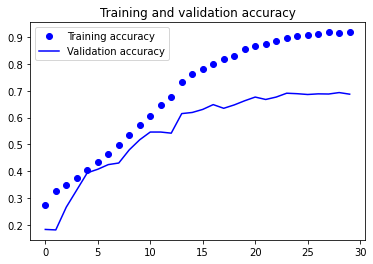

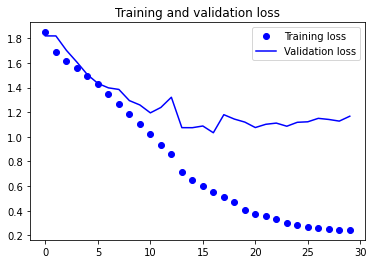

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**Save/Reload Models**

In [ ]:
from keras.models import load_model
fashion_model.save("/content/drive/MyDrive/Speech Recognition/Best Model/zcr_spec_model_best")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Speech Recognition/Best Model/zcr_spec_model_best/assets


#**Testing**

**Predict Classes**

In [ ]:
predicted_classes = fashion_model.predict(energy_test)
predicted_classes_normalized = np.argmax(np.round(predicted_classes),axis=1)

In [ ]:
ZCR_label_test = np.argmax(np.round(energy_label_test),axis=1)

In [ ]:
predicted_classes_normalized

array([3, 0, 1, ..., 5, 0, 0])

In [ ]:
correct = np.where(predicted_classes_normalized==ZCR_label_test)[0]
print ("Found %d correct labels" % len(correct))

incorrect = np.where(predicted_classes_normalized!=ZCR_label_test)[0]
print ("Found %d incorrect labels" % len(incorrect))

Found 2617 correct labels
Found 1104 incorrect labels


**Test Data Scores**

In [ ]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(ZCR_label_test, predicted_classes_normalized, target_names=lb.classes_))

              precision    recall  f1-score   support

       angry       0.64      0.81      0.71       613
     disgust       0.76      0.71      0.74       649
        fear       0.71      0.65      0.68       641
       happy       0.70      0.69      0.70       676
     neutral       0.72      0.64      0.68       535
         sad       0.71      0.71      0.71       607

    accuracy                           0.70      3721
   macro avg       0.71      0.70      0.70      3721
weighted avg       0.71      0.70      0.70      3721



**Confusuin Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=ZCR_label_test, y_pred=predicted_classes_normalized)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[494  29  20  45  20   5]
 [ 64 464  31  29  16  45]
 [ 59  35 416  54  21  56]
 [ 74  26  56 468  30  22]
 [ 51  20  26  50 344  44]
 [ 33  37  39  20  47 431]]


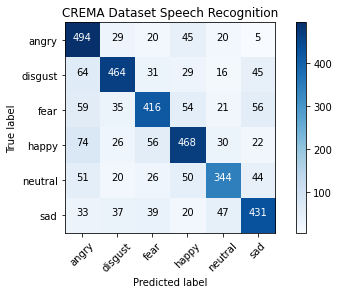

In [ ]:
plot_confusion_matrix(cm=cm, classes=lb.classes_, title='CREMA Dataset Speech Recognition')